In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras_tuner.tuners import RandomSearch


In [18]:
# Cargar datos
real_data = pd.read_csv('pb_inputs_real_dia.csv', parse_dates=['Fecha'], index_col='Fecha')
forecast_data = pd.read_csv('pb_inputs_frcst_dia.csv', parse_dates=['Fecha'], index_col='Fecha')

# cambio de formato
real_data = real_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))
forecast_data = forecast_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))


In [19]:
real_data['Precio Bolsa Nacional'][0]#+1

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_6098/1334647813.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real_data['Precio Bolsa Nacional'][0]#+1


np.float64(32.8681)

In [20]:
# Asegurar frecuencia diaria
real_data = real_data.asfreq('D')
forecast_data = forecast_data.asfreq('D')

In [21]:
# Verificar que el dataframe contiene datos desde 2000 hasta la fecha actual
fecha_inicio = '2000-01-01'
fecha_fin = '2025-12-31'
real_data = real_data.reindex(pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D'))

In [22]:
# Rellenar valores faltantes en variables exógenas (ONI proyectado)
real_data['ONI'].fillna(method='ffill', inplace=True)

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_6098/3455126431.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  real_data['ONI'].fillna(method='ffill', inplace=True)
/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_6098/3455126431.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  real_data['ONI'].fillna(method='ffill', inplace=True)


In [23]:
# Unir datos reales y proyectados
full_data = real_data.copy()
full_data.update(forecast_data)

In [24]:
# Dividir en entrenamiento y prueba
train = real_data[:'2024-12-31']
test = real_data['2025-01-01':'2025-01-31']

In [25]:
# Definir variables predictoras y objetivo
features = ['ONI', 'Demanda Comercial']  # Agrega más si es necesario
target = 'Precio Bolsa Nacional'

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

In [26]:
X_test

,ONI,Demanda Comercial
2025-01-01,-0.5,178.823
2025-01-02,-0.5,207.586
2025-01-03,-0.5,215.503
2025-01-04,-0.5,209.158
2025-01-05,-0.5,196.703
2025-01-06,-0.5,200.215
2025-01-07,-0.5,224.509
2025-01-08,-0.5,234.943
2025-01-09,-0.5,234.120
2025-01-10,-0.5,236.571


In [27]:
# verificación de NaNs en los sets de entrenamiento y prueba
print(X_train.isna().sum().sum())  # Cantidad total de NaNs en X_train
print(X_test.isna().sum().sum())   # Cantidad total de NaNs en X_test

0
0


In [28]:
print(X_test.isna())

              ONI  Demanda Comercial
2025-01-01  False              False
2025-01-02  False              False
2025-01-03  False              False
2025-01-04  False              False
2025-01-05  False              False
2025-01-06  False              False
2025-01-07  False              False
2025-01-08  False              False
2025-01-09  False              False
2025-01-10  False              False
2025-01-11  False              False
2025-01-12  False              False
2025-01-13  False              False
2025-01-14  False              False
2025-01-15  False              False
2025-01-16  False              False
2025-01-17  False              False
2025-01-18  False              False
2025-01-19  False              False
2025-01-20  False              False
2025-01-21  False              False
2025-01-22  False              False
2025-01-23  False              False
2025-01-24  False              False
2025-01-25  False              False
2025-01-26  False              False
2

X_train_seq shape: (9122, 10, 2), y_train_seq shape: (9122,)
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 35101.6328
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36521.0430
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33558.7109
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28942.9199
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26031.7383
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26772.4082
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25437.9414
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21113.4980
Epoch 9/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22456.6270
Epoch 10/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37465.6875
Epoch 11/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29055.0508
Epoch 12/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25817.3535
Epoch 13/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25492.9902
Epoch 14/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27030.7344
Epoch 15/50


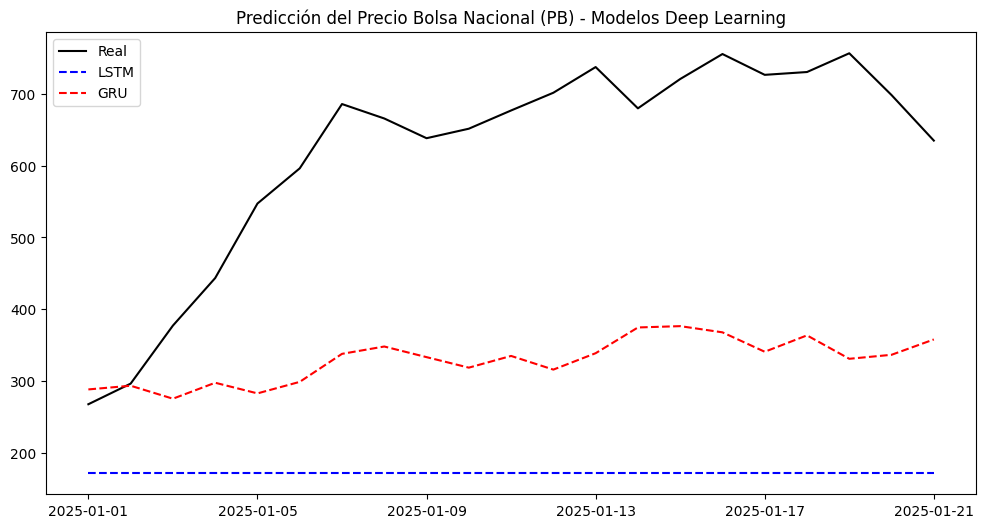

In [29]:
# Convertir datos en formato adecuado para modelos de deep learning
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Asegurar que los datos están en formato numpy
X_train_seq, y_train_seq = create_sequences(X_train.to_numpy(), y_train.to_numpy())
X_test_seq, y_test_seq = create_sequences(X_test.to_numpy(), y_test.to_numpy())

# Verificar dimensiones de entrada
print(f"X_train_seq shape: {X_train_seq.shape}, y_train_seq shape: {y_train_seq.shape}")

# Modelo base LSTM
lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    LSTM(50, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=1)

# Predicción inicial LSTM
y_pred_lstm = lstm_model.predict(X_test_seq)

# Modelo base GRU
gru_model = Sequential([
    GRU(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    GRU(50, activation='relu'),
    Dense(1)
])

gru_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=1)

# Predicción inicial GRU
y_pred_gru = gru_model.predict(X_test_seq)

# Evaluación inicial
lstm_mse = mean_squared_error(y_test_seq, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_seq, y_pred_lstm)

gru_mse = mean_squared_error(y_test_seq, y_pred_gru)
gru_rmse = np.sqrt(gru_mse)
gru_mape = mean_absolute_percentage_error(y_test_seq, y_pred_gru)

# Resultados iniciales
deep_learning_metrics = pd.DataFrame({
    "LSTM": {"MSE": lstm_mse, "RMSE": lstm_rmse, "MAPE": lstm_mape},
    "GRU": {"MSE": gru_mse, "RMSE": gru_rmse, "MAPE": gru_mape}
}).T

print(deep_learning_metrics)

# Visualización de predicciones iniciales
plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(y_test_seq)], y_test_seq, label='Real', color='black')
plt.plot(test.index[:len(y_pred_lstm)], y_pred_lstm, label='LSTM', linestyle='dashed', color='blue')
plt.plot(test.index[:len(y_pred_gru)], y_pred_gru, label='GRU', linestyle='dashed', color='red')
plt.legend()
plt.title('Predicción del Precio Bolsa Nacional (PB) - Modelos Deep Learning')
plt.show()

Archivo 'predicciones_DL_inicial.csv' exportado con éxito.
Reloading Tuner from tuner_results/LSTM_Tuning/tuner0.json
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 23142.3262
Epoch 2/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21716.7520
Epoch 3/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22979.8223
Epoch 4/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22198.7148
Epoch 5/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25903.0879
Epoch 6/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20974.8301
Epoch 7/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29366.3926
Epoch 8/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 38714.2148
Epoch 9/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34772.2969
Epoch 10/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41122.4023
Epoch 11/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34420.2109
Epoch 12/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34256.9141
Epoch 13/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29701.1836
Epoch 14/50
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 33339.3281
Epoch 15/50


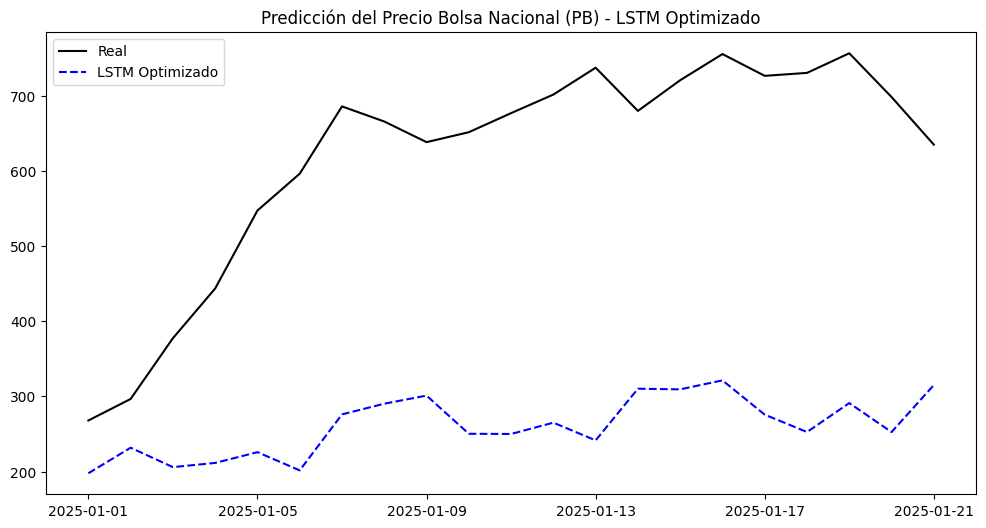

Archivo 'predicciones_DL_opt.csv' exportado con éxito.


In [30]:
# Exportar predicciones iniciales
forecast_df = pd.DataFrame({
    'Fecha': test.index[:len(y_test_seq)],
    'Real': y_test_seq.flatten(),
    'LSTM (Inicial)': y_pred_lstm.flatten(),
    'GRU (Inicial)': y_pred_gru.flatten()
})

forecast_df.to_csv("predicciones_DL_inicial.csv", index=False, encoding='utf-8')
print("Archivo 'predicciones_DL_inicial.csv' exportado con éxito.")

# ---------------------------------------------
# OPTIMIZACIÓN DE HIPERPARÁMETROS CON KERAS TUNER
# ---------------------------------------------

def build_lstm_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   activation='relu',
                   return_sequences=True,
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(LSTM(units=hp.Int('units_2', min_value=32, max_value=128, step=32),
                   activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.01, 0.1])), loss='mse')
    return model

# Búsqueda de hiperparámetros
tuner = RandomSearch(build_lstm_model, objective='val_loss', max_trials=5, executions_per_trial=1, directory='tuner_results', project_name='LSTM_Tuning')

tuner.search(X_train_seq, y_train_seq, epochs=20, validation_data=(X_test_seq, y_test_seq), verbose=1)

# Mejor modelo
best_lstm = tuner.get_best_models(num_models=1)[0]

# Entrenar mejor modelo
best_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, verbose=1)

# Predicción optimizada LSTM
y_pred_lstm_opt = best_lstm.predict(X_test_seq)

# Evaluación optimizada
lstm_mse_opt = mean_squared_error(y_test_seq, y_pred_lstm_opt)
lstm_rmse_opt = np.sqrt(lstm_mse_opt)
lstm_mape_opt = mean_absolute_percentage_error(y_test_seq, y_pred_lstm_opt)

# Resultados optimizados
optimized_dl_metrics = pd.DataFrame({
    "LSTM Optimizado": {"MSE": lstm_mse_opt, "RMSE": lstm_rmse_opt, "MAPE": lstm_mape_opt}
}).T

print(optimized_dl_metrics)

# Visualización de predicciones optimizadas
plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(y_test_seq)], y_test_seq, label='Real', color='black')
plt.plot(test.index[:len(y_pred_lstm_opt)], y_pred_lstm_opt, label='LSTM Optimizado', linestyle='dashed', color='blue')
plt.legend()
plt.title('Predicción del Precio Bolsa Nacional (PB) - LSTM Optimizado')
plt.show()

# Exportar predicciones optimizadas
forecast_df_opt = pd.DataFrame({
    'Fecha': test.index[:len(y_test_seq)],
    'Real': y_test_seq.flatten(),
    'LSTM (Optimizado)': y_pred_lstm_opt.flatten()
})

forecast_df_opt.to_csv("predicciones_DL_opt.csv", index=False, encoding='utf-8')
print("Archivo 'predicciones_DL_opt.csv' exportado con éxito.")